In [2]:
import os
import shutil
import random
import math
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
from torchvision import transforms
import os
import zipfile
from pathlib import Path
import requests
from torch.utils.data import DataLoader
from torchinfo import summary
from timeit import default_timer as timer
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple 

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = Path("D:\\Study\\resics_applied_ml_project\\splitted_data")
train_dir = image_path / "train/"
test_dir = image_path / "test/"

In [ ]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
NUM_WORKERS = os.cpu_count()
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  class_names = train_data.classes
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x16b20656200>,
 ['airplane',
  'airport',
  'baseball_diamond',
  'basketball_court',
  'beach',
  'bridge',
  'chaparral',
  'church',
  'circular_farmland',
  'cloud',
  'commercial_area',
  'dense_residential',
  'desert',
  'forest',
  'freeway',
  'golf_course',
  'ground_track_field',
  'harbor',
  'industrial_area',
  'intersection',
  'island',
  'lake',
  'meadow',
  'medium_residential',
  'mobile_home_park',
  'mountain',
  'overpass',
  'palace',
  'parking_lot',
  'railway',
  'railway_station',
  'rectangular_farmland',
  'river',
  'roundabout',
  'runway',
  'sea_ice',
  'ship',
  'snowberg',
  'sparse_residential',
  'stadium',
  'storage_tank',
  'tennis_court',
  'terrace',
  'thermal_power_station',
  'wetland'])

: 

In [7]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
model = torchvision.models.resnet50(weights=weights).to(device)

In [13]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
dropout_rate = 0.5

model.fc = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(num_ftrs, 45)
).to(device)

In [ ]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 45]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(filter(lambda p: p.requires_grad, model.parameters())),
    lr=0.001
)

In [16]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [ ]:
def mc_dropout_predict(model: torch.nn.Module,
                       dataloader: torch.utils.data.DataLoader,
                       loss_fn: torch.nn.Module,
                       device: torch.device,
                       num_samples: int = 20) -> Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor]]:
    """
    Performs MC-Dropout predictions.

    Args:
        model: PyTorch model with dropout layers.
        dataloader: DataLoader for the data to predict on.
        loss_fn: Loss function (optional).
        device: Target device.
        num_samples: Number of forward passes for MC-Dropout.

    Returns:
        A tuple of (mean_predictions, predictive_uncertainty, all_predictions_softmax).
        mean_predictions: Softmax probabilities averaged over MC samples.
        predictive_uncertainty: Variance of softmax probabilities over MC samples (or other uncertainty metric).
        all_predictions_softmax: List of softmax probabilities for each MC sample.
    """
    model.eval()  
    enable_dropout(model)

    all_predictions_softmax = []
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            batch_predictions_softmax = []
            for _ in range(num_samples):
                pred_logits = model(X)
                batch_predictions_softmax.append(torch.softmax(pred_logits, dim=1))
            stacked_batch_preds = torch.stack(batch_predictions_softmax)
            all_predictions_softmax.append(stacked_batch_preds)
    all_predictions_softmax_tensor = torch.cat(all_predictions_softmax, dim=1)
    mean_predictions = torch.mean(all_predictions_softmax_tensor, dim=0)
    predictive_uncertainty = torch.var(all_predictions_softmax_tensor, dim=0)
    return mean_predictions, predictive_uncertainty, all_predictions_softmax_tensor


In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch."""
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch."""
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          test_pred_logits = model(X)
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [22]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model."""
  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
  model.to(device)
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
  return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6448 | train_acc: 0.8190 | test_loss: 0.2826 | test_acc: 0.9222
Epoch: 2 | train_loss: 0.2338 | train_acc: 0.9287 | test_loss: 0.2324 | test_acc: 0.9294
Epoch: 3 | train_loss: 0.1446 | train_acc: 0.9559 | test_loss: 0.2432 | test_acc: 0.9402
Epoch: 4 | train_loss: 0.0945 | train_acc: 0.9701 | test_loss: 0.2409 | test_acc: 0.9423
Epoch: 5 | train_loss: 0.0857 | train_acc: 0.9728 | test_loss: 0.2441 | test_acc: 0.9387
[INFO] Total training time: 977.269 seconds


In [ ]:
num_mc_samples = 50
mean_preds, uncertainty, all_softmax_outputs = mc_dropout_predict(
    model=model,
    dataloader=test_dataloader,
    loss_fn=None,
    device=device,
    num_samples=num_mc_samples
)

# "mean_preds" gives you the averaged prediction.
# "uncertainty" (e.g., variance) gives a measure of how much the predictions vary across the MC samples.
# Potentially, we can sum the variance across classes for an overall uncertainty per input,
# or look at the variance of the predicted class probability.
# "all_softmax_outputs" contains all raw softmax outputs for further analysis if needed.

final_predictions = torch.argmax(mean_preds, dim=1)
overall_image_uncertainty = torch.sum(uncertainty, dim=1)

print(f"Mean predictions shape: {mean_preds.shape}")
print(f"Uncertainty (variance) shape: {uncertainty.shape}")
print(f"Final predicted classes shape: {final_predictions.shape}")
print(f"Overall image uncertainty shape: {overall_image_uncertainty.shape}")

Mean predictions shape: torch.Size([6300, 45])
Uncertainty (variance) shape: torch.Size([6300, 45])
Final predicted classes shape: torch.Size([6300])
Overall image uncertainty shape: torch.Size([6300])


In [33]:
max(mean_preds[0]), min(mean_preds[0]), mean_preds[2000]

(tensor(1.0000, device='cuda:0'),
 tensor(1.0030e-13, device='cuda:0'),
 tensor([5.1299e-05, 1.0415e-04, 5.9368e-05, 4.2562e-05, 2.4151e-04, 4.3892e-04,
         5.5269e-06, 6.1792e-06, 9.4669e-07, 4.0270e-06, 2.4550e-07, 1.2269e-08,
         1.1149e-06, 8.0524e-07, 2.9530e-01, 1.4519e-04, 5.2413e-05, 1.0577e-06,
         7.9660e-06, 1.4959e-04, 4.5670e-07, 9.2910e-08, 6.4570e-05, 2.1660e-06,
         2.5553e-05, 8.6194e-07, 4.3120e-03, 6.7582e-06, 2.1711e-05, 6.9053e-01,
         5.6782e-04, 1.1682e-06, 1.4970e-05, 3.6571e-05, 3.1214e-03, 3.4626e-08,
         2.7628e-05, 8.9079e-07, 4.4194e-03, 2.1994e-07, 1.8752e-05, 1.7004e-04,
         5.0287e-07, 4.9627e-06, 3.4460e-05], device='cuda:0'))

In [ ]:
output_dir = Path("./output_mc_dropout")
os.makedirs(output_dir, exist_ok=True)

if "model" in locals() and model is not None:
    model_save_path = output_dir / "trained_resnet50_mc_dropout_model.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

Model saved to output_mc_dropout\trained_resnet50_mc_dropout_model.pth


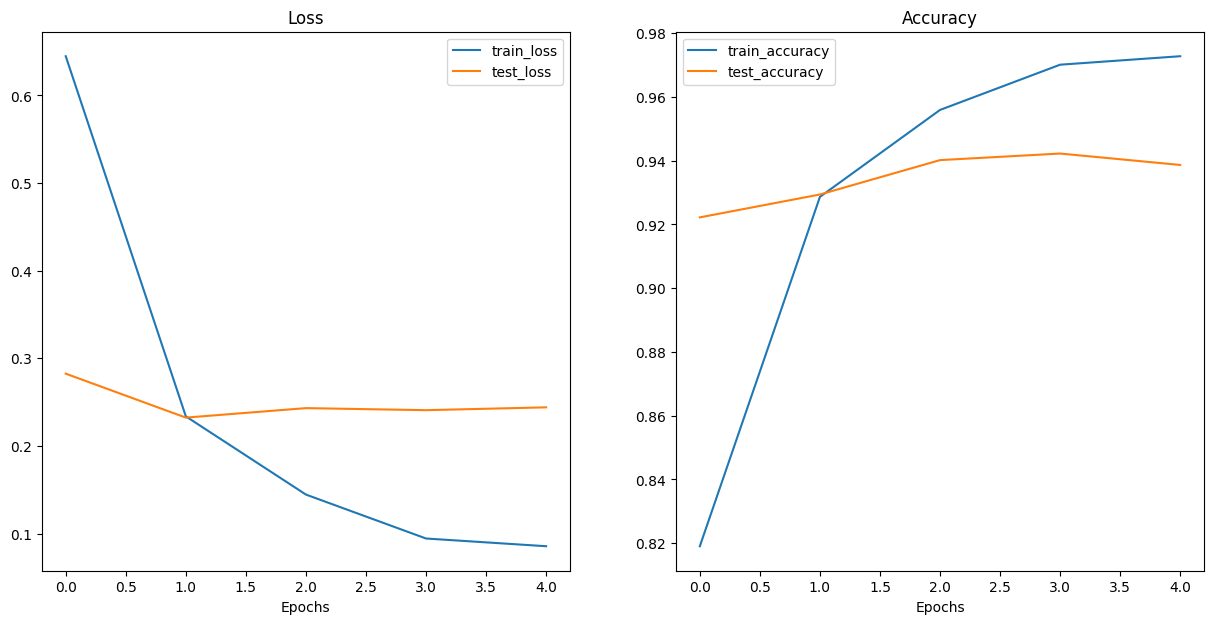

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

if results and all(k in results for k in ["train_loss", "test_loss", "train_acc", "test_acc"]):
    plot_loss_curves(results)
else:
    print("Skipping plotting loss curves as training results are not available or incomplete.")